# Create new utility function

Import data.

In [1]:
%reload_ext autoreload
%autoreload 2

import rdkit
rdkit.Chem.Draw.IPythonConsole.ipython_maxProperties = -1

import dgym as dg

# load all data
print('load data')
path = '../../dgym-data'

deck = dg.MoleculeCollection.load(
    f'{path}/DSi-Poised_Library_annotated.sdf',
    reactant_names=['reagsmi1', 'reagsmi2', 'reagsmi3']
)

reactions = dg.ReactionCollection.from_json(
    path = f'{path}/All_Rxns_rxn_library.json',
    smarts_col = 'reaction_string',
    classes_col = 'functional_groups'
)

load data


In [6]:
deck.molecules[6].annotations

{'HBA': 2,
 'TPSA': 30.71,
 'RotBonds': 3,
 'reagsmi1': 'C=1C=C(NN1)C=2C=CN=CC2',
 'reagsmi2': 'CCCBr',
 'reag1': 'EN300-69165',
 'Catalog ID': 'Z1381484542',
 'MW': 187.111,
 'MW (desalted)': 187.241,
 'ClogP': 2.015,
 'logS': -1.323,
 'HBD': 0,
 'reag2': 'EN300-19391',
 'reaction': 'OXYME',
 'RDB type': 'sRDB',
 'design_cycle': 0,
 'smiles': 'CCCn1nccc1-c1ccncc1'}

In [2]:
building_blocks = dg.datasets.disk_loader(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630.sdf')
fingerprints = dg.datasets.fingerprints(f'{path}/out/Enamine_Building_Blocks_Stock_262336cmpd_20230630_atoms.fpb')

Create inputs to the DrugEnv.

In [3]:
import numpy as np
from dgym.envs.library_designer import LibraryDesigner, Generator
from dgym.envs.oracle import DGLOracle, RDKitOracle, DockingOracle
from dgym.envs.evaluator import ClassicEvaluator, UtilityFunction

# create library designer
library_designer = LibraryDesigner(
    reactions, Generator(building_blocks, fingerprints)
)

# create molecular properties
log_P_oracle = RDKitOracle('MolLogP')
weight_oracle = RDKitOracle('HeavyAtomMolWt')
# log_S_oracle = DGLOracle('GCN_canonical_ESOL')

# create evaluators
log_P_evaluator = ClassicEvaluator(ideal=(1, 4), acceptable=(0, 5))
log_S_evaluator = ClassicEvaluator(ideal=(-2, 0), acceptable=(-4, 0.5))
weight_evaluator = ClassicEvaluator(ideal=(400, 500), acceptable=(300, 600))

# create utility function
utility_function = UtilityFunction(
    oracles = [
        weight_oracle,
        log_P_oracle
    ],
    evaluators = [
        weight_evaluator,
        log_P_evaluator
    ],
    strategy = lambda x: np.prod(x, axis=0)
)

First, set up the environment.

In [4]:
from dgym.envs.drug_env import DrugEnv
from dgym.agents import SequentialDrugAgent
from tqdm.notebook import tqdm

class Experiment:
    
    def __init__(self, drug_agent, drug_env):
        self.drug_agent = drug_agent
        self.drug_env = drug_env
    
    def run(self, num_trials):
        
        results = []
        for trial in range(num_trials):

            observations, info = drug_env.reset()

            pbar = tqdm(total = drug_env.budget)
            while True:
                print(observations.annotations)
                action = drug_agent.act(observations)
                observations, _, terminated, truncated, _ = drug_env.step(action)
                pbar.n = len(drug_env.library)
                pbar.update()
                if terminated or truncated:
                    break

            result = {
                'trial': trial,
                'epsilon': self.drug_agent.epsilon,
                'temperature': self.drug_agent.temperature,
                'num_analogs': self.drug_agent.num_analogs,
                'branch_factor': self.drug_agent.branch_factor
            }

            if terminated:
                cost = len(drug_env.library) - len(drug_env._library_0)
                result.update({'cost': cost, 'outcome': 1})

            if truncated:
                result.update({'outcome': 0})

            results.append(result)

        return results

In [12]:
deck[[244, 40, 50]].molecules[2].annotations

{'HBA': 2,
 'TPSA': 38.33,
 'RotBonds': 2,
 'reagsmi1': 'CC=1C(N)=CC=CC1Cl',
 'reagsmi2': 'OC(=O)[C@@H]1CCCO1',
 'reag1': 'EN300-19575',
 'Catalog ID': 'Z1545312521',
 'MW': 239.698,
 'MW (desalted)': 239.698,
 'ClogP': 2.227,
 'logS': -3.239,
 'HBD': 1,
 'reag2': 'EN300-104395',
 'reaction': 'AMIDE',
 'RDB type': 'sRDB',
 'design_cycle': 0,
 'smiles': 'Cc1c(Cl)cccc1NC(=O)[C@@H]1CCCO1'}

In [5]:
drug_env = DrugEnv(
    library_designer,
    library = deck[[244]],
    assays = utility_function.oracles,
    budget = 200,
    utility_function = utility_function,
)

drug_agent = SequentialDrugAgent(
    action_space = drug_env.action_space,
    utility_function = utility_function,
    epsilon = 0.0,
    temperature = 0.1,
    num_analogs = 1,
    branch_factor = 1
)

experiment = Experiment(drug_agent, drug_env)
result = experiment.run(1)

  0%|          | 0/200 [00:00<?, ?it/s]

Empty DataFrame
Columns: []
Index: [0]
Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    design_cycle                             smiles  HeavyAtomMolWt
0            NaN                                NaN             NaN
1            1.0  Cc1cc(Br)cc(C(=O)Nc2ccc(C)cc2O)c1         306.074
2            1.0  Cc1cc(Br)cc(C(=O)Nc2ccc(C)cc2O)c1         306.074
3            1.0  Cc1cc(Br)cc(C(=O)Nc2ccc(C)cc2O)c1         306.074
4            1.0  Cc1cc(Br)cc(C(=O)Nc2ccc(C)cc2O)c1         306.074
5            1.0  Cc1cc(Br)cc(C(=O)Nc2ccc(C)cc2O)c1         306.074
6            1.0  Cc1cc(Br)cc(C(=O)Nc2ccc(C)cc2O)c1         306.074
7            1.0  Cc1cc(Br)cc(C(=O)Nc2ccc(C)cc2O)c1         306.074
8            1.0  Cc1cc(Br)cc(C(=O)Nc2ccc(C)cc2O)c1         306.074
9            1.0  Cc1cc(Br)cc(C(=O)Nc2ccc(C)cc2O)c1         306.074
10           1.0  Cc1cc(Br)cc(C(=O)Nc2ccc(C)cc2O)c1         306.074
    design_cycle                             smiles  HeavyAtomMolWt
0      

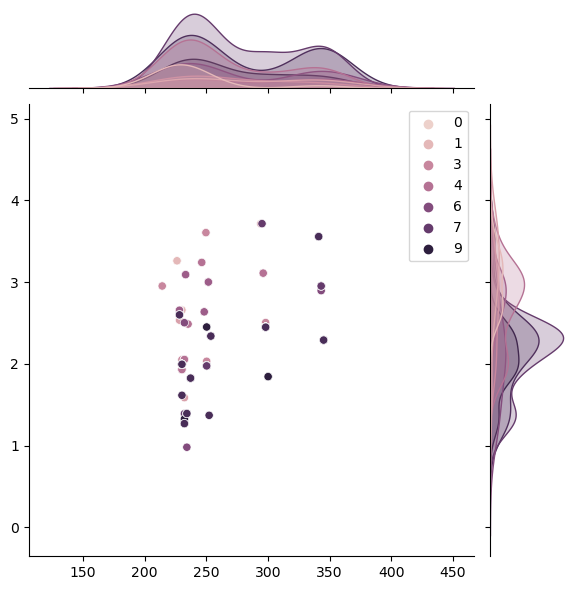

In [14]:
import seaborn as sns

sns.jointplot(
    x=weight_oracle(experiment.drug_env.library),
    y=log_P_oracle(experiment.drug_env.library),
    hue=[l.design_cycle for l in experiment.drug_env.library]
)

In [66]:
# [l.update_annotations() for l in experiment.drug_env.library]

In [113]:
experiment.drug_env.library.update_annotations({'test': '0'})

MoleculeCollection with 51 Molecules

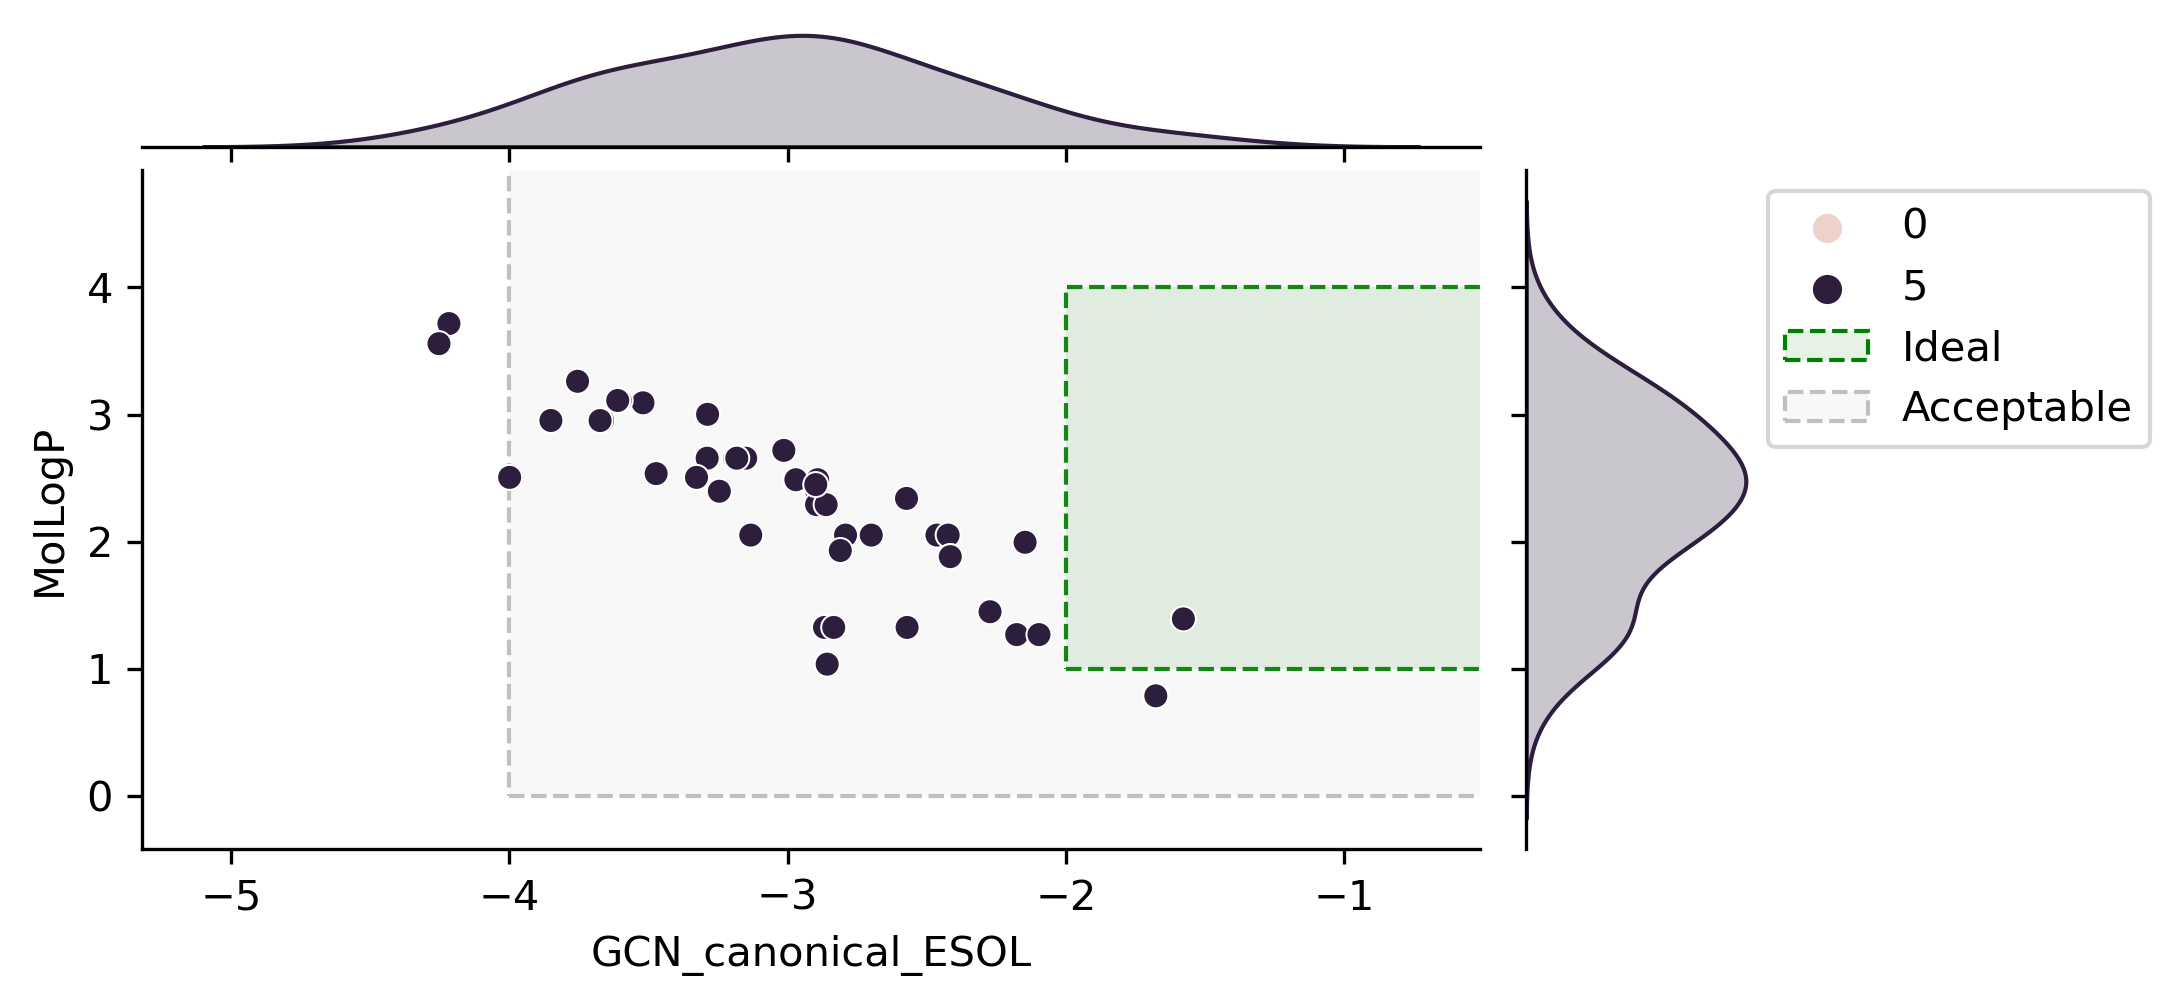

In [112]:
experiment.drug_env.utility_function.plot(experiment.drug_env.library)

Experimenting with Agent hyperparameters.

In [64]:
results = []
temperatures = [0.0, 0.2, 1.0]
for temperature in temperatures:
    print(temperature)
    
    drug_env = DrugEnv(
        library_designer,
        library = deck[20:22],
        assays = utility_function.oracles,
        budget = 500,
        utility_function = utility_function,
    )

    drug_agent = SequentialDrugAgent(
        action_space = drug_env.action_space,
        utility_function = utility_function,
        epsilon = 0.5,
        temperature = temperature,
        num_analogs = 2,
        branch_factor = 1
    )

    experiment = Experiment(drug_agent, drug_env)
    result = experiment.run(1)
    results.extend(result)

0.0


  0%|          | 0/500 [00:00<?, ?it/s]

{'type': 0, 'molecules': [0], 'parameters': {'num_analogs': 2, 'temperature': 0.0}}
{'type': 1, 'molecules': [77], 'parameters': {}}
{'type': 0, 'molecules': [77], 'parameters': {'num_analogs': 2, 'temperature': 0.0}}
{'type': 1, 'molecules': [2], 'parameters': {}}
{'type': 0, 'molecules': [27], 'parameters': {'num_analogs': 2, 'temperature': 0.0}}
{'type': 1, 'molecules': [181], 'parameters': {}}
{'type': 0, 'molecules': [145], 'parameters': {'num_analogs': 2, 'temperature': 0.0}}
{'type': 1, 'molecules': [145], 'parameters': {}}
{'type': 0, 'molecules': [145], 'parameters': {'num_analogs': 2, 'temperature': 0.0}}
{'type': 1, 'molecules': [447], 'parameters': {}}
{'type': 0, 'molecules': [386], 'parameters': {'num_analogs': 2, 'temperature': 0.0}}
0.2


  0%|          | 0/500 [00:00<?, ?it/s]

{'type': 0, 'molecules': [1], 'parameters': {'num_analogs': 2, 'temperature': 0.2}}
1.0


  0%|          | 0/500 [00:00<?, ?it/s]

{'type': 0, 'molecules': [1], 'parameters': {'num_analogs': 2, 'temperature': 1.0}}
{'type': 1, 'molecules': [51], 'parameters': {}}
{'type': 0, 'molecules': [7], 'parameters': {'num_analogs': 2, 'temperature': 1.0}}


In [51]:
def ecdf(costs):
    costs = np.array([c for c in costs])
    costs_sorted = np.sort(costs)
    probs = 1. * np.arange(1, len(costs) + 1) / len(costs)

    costs_sorted = np.concatenate([[0.0], costs_sorted])
    probs = np.concatenate([[0.0], probs])
    
    return costs_sorted, probs

In [47]:
import pandas as pd

data = pd.DataFrame()
for temperature in temperatures:
    raw_costs = [r['cost'] for r in df.to_dict('records') if r['temperature'] == temperature]
    cost, prob = ecdf(raw_costs)
    temp = pd.DataFrame({'cost': cost, 'prob': prob, 'temperature': temperature})
    data = pd.concat([data, temp])

NameError: name 'df' is not defined

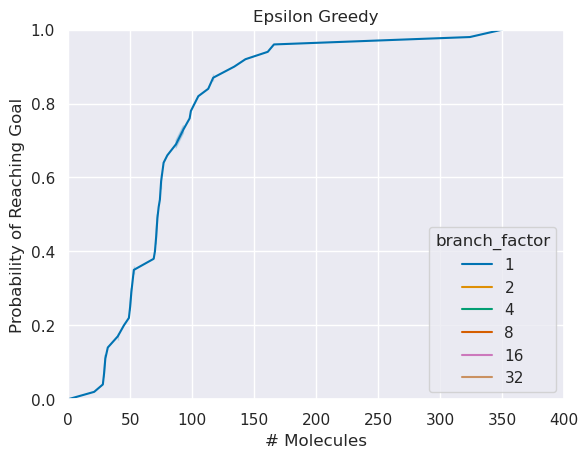

In [64]:
sns.set()
g = sns.lineplot(
    data,
    x='cost',
    y='prob',
    hue='epsilon',
    palette='colorblind'
)

g.set_title('Epsilon Greedy')
g.set_xlabel('# Molecules')
g.set_ylabel('Probability of Reaching Goal')
g.set_ylim([0, 1])
g.set_xlim(0, 500)

plt.gcf().set_dpi(150)
plt.show()

Draw lineage of best molecule.

In [65]:
from rdkit.Chem import Draw

utility = drug_agent.policy(observations)
index = int(np.argsort(utility)[-1])

mol = drug_env.library[index]
lineage = [mol]
while mol.inspiration:
    mol = mol.inspiration
    lineage.insert(0, mol)

assay_results = [assay(lineage) for assay in assays]
results = [
    utility_function.score(properties)
    for properties in zip(*assay_results)
]

display(Draw.MolsToGridImage(
    [m.mol for m in lineage],
    molsPerRow=8,
    maxMols=10_000
))

print('\t\t'.join(map(str, results)))
display(*zip(*assay_results))

NameError: name 'assays' is not defined

## Experimenting with a basic optimization loop.

In [568]:
mol = deck[649]
for _ in range(10):
    analogs = library_designer.design(
        molecule = mol,
        num_analogs = 10,
        temperature = 0.2
    )

    utility = utility_function(analogs)
    mol = analogs[np.argmax(utility).item()]
    
    print(np.mean(utility))
    print(utility)
    
    if np.mean(utility) > 0.8:
        break

0.5397510310764196
[0.49890077 0.57199806 0.69466764 0.59846324 0.62399361 0.36748483
 0.47118986 0.58870894 0.65977448 0.32232889]
0.43620898921254875
[0.29152273 0.53804131 0.41093391 0.25644882 0.26980297 0.57639092
 0.26024414 0.27396596 0.64558154 0.83915758]
0.6038911659871669
[0.66197159 0.55216628 0.47245089 0.74007082 0.70400564 0.5265
 0.5876894  0.53414101 0.54129493 0.7186211 ]
0.45719563878539393
[0.57177836 0.63720638 0.42451275 0.27850894 0.66178131 0.54546112
 0.47808598 0.29059224 0.39957283 0.2844565 ]
0.39004657261444114
[0.1344528  0.23124879 0.51515621 0.73354286 0.37682197 0.69252259
 0.53042138 0.32568662 0.3132071  0.04740542]
0.7226556127214199
[0.74839997 0.57448602 0.83398745 0.64956236 0.75433129 0.93759596
 0.37788251 0.66616935 0.78579122 0.89835   ]
0.6009625735370067
[0.94947791 0.53598118 0.50276512 0.65190107 0.24839555 0.90283161
 0.4214831  0.78108317 0.93759596 0.07811106]
0.6146980915800854
[0.66298455 0.55671334 0.44479933 0.78225815 0.59899294 0.

In [ ]:
# create evaluators
log_S_evaluator = ClassicEvaluator(ideal=(-2, 0), acceptable=(-4, 0.5))
log_P_evaluator = ClassicEvaluator(ideal=(1, 4), acceptable=(0, 5))

In [577]:
log_S_oracle([analogs[9]])

[-3.98738694190979]

In [578]:
utility_function([analogs[9]])

array([0.50315326])

In [572]:
log_P_oracle([analogs[9]])

[2.7784000000000004]